## Import libraries

In [42]:
import numpy as np
from numpy import linalg
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime
np.random.seed(123456)

## Load data

In [43]:
X, y = datasets.load_boston(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123456)

## Results using Sklearn

In [44]:
linReg = linear_model.LinearRegression()
start = datetime.now()
_ = linReg.fit(X=X_train, y=y_train)
end = datetime.now()
print("Time taken = {}".format(end - start))
print("Train R-square = {}".format(linReg.score(X_train, y_train)))
print("Test R-square = {}".format(linReg.score(X_test, y_test)))

Time taken = 0:00:00.018789
Train R-square = 0.7280149810444595
Test R-square = 0.7613410334735791


## Residual plot
#### Using sklearn model
Ideally, we should not see any pattern, periodicity, divergence, linear or polynomial relationship between axes.

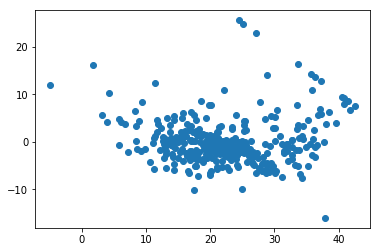

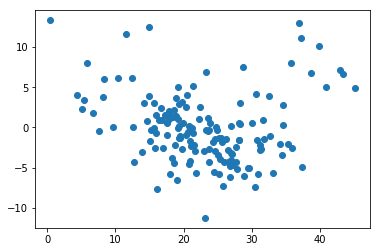

In [45]:
predictions_train = linReg.predict(X_train)
predictions_test = linReg.predict(X_test)

# Plot train and test separately
plt.scatter(predictions_train, y_train - predictions_train)
plt.figure(2)
plt.scatter(predictions_test, y_test - predictions_test)
plt.show()

## Use our own function
#### using matrix inverse method (what is it called?)
Reference for the formula proof - [OLS in Matrix form - Stanford](https://web.stanford.edu/~mrosenfe/soc_meth_proj3/matrix_OLS_NYU_notes.pdf "OLS in Matrix form - Stanford")

In [46]:
def myLinearRegression(X=None, y=None):
    '''
    X : numpy ndarray of dimension n x p. n is number of rows,
        p is number of columns
    y : numpy array of target values of dimension n x 1.
    Return : beta coeffiecients. First coeff is for bais.
             Dimension : p+1 x 1
    '''
    # append 1 to each train data point to represent bias coeff
    a = np.reshape([[1] * X.shape[0]], (-1, 1))
    X_lr = np.append(a, X, axis=1)
    
    # find estimate to beta parameters
    # beta_hat = inv(x'x) * x' * y
    beta_hat = np.matmul(np.matmul(linalg.inv(np.matmul(np.transpose(X_lr), X_lr)), np.transpose(X_lr)), y)
    
    return beta_hat

## Our function is accurate. But are we faster than sklearn?
May be for data of this small size!

In [47]:
start = datetime.now()
beta_hat = myLinearRegression(X=X_train, y=y_train)
end = datetime.now()

print("Time taken = {}".format(end - start))

# Test for correctness - emulate fit process by assigning coeffs.
mylinReg = linear_model.LinearRegression()
mylinReg.coef_ = beta_hat[1:]
mylinReg.intercept_ = beta_hat[0]

print(mylinReg.score(X_train, y_train))
print(mylinReg.score(X_test, y_test))

Time taken = 0:00:00.011117
0.7280149810444594
0.7613410334735645


## Residual plot
#### Using our model
Ideally we should see exactly same plots

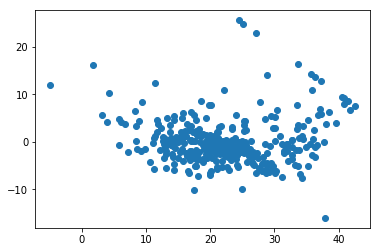

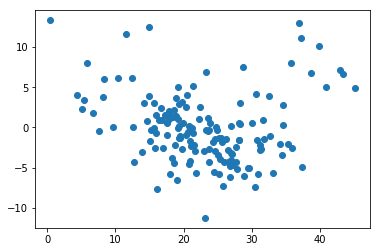

In [48]:
predictions_train = mylinReg.predict(X_train)
predictions_test = mylinReg.predict(X_test)

# Plot train and test separately
plt.scatter(predictions_train, y_train - predictions_train)
plt.figure(2)
plt.scatter(predictions_test, y_test - predictions_test)
plt.show()

## Some sanity checks

In [49]:
a = np.reshape([1] * X_train.shape[0], (-1, 1))
X_lr = np.append(a, X_train, axis=1)

# Residuals aka e.
residuals = y_train - predictions_train

# Check X'e - should be zero -> implies uncorrelation of X and e.
x_e = np.matmul(np.transpose(X_lr), residuals)
print("X'e = {:10.8f}".format(np.sum(x_e)))

# Check sum of residuals - it should be zero (or numerically very small)
print("Sum of residuals on train = {:10.8f}".format(np.sum(residuals)))

# Check if predicted values of y are uncorrelated with residuals - should be 0
a = np.matmul(np.transpose(predictions_train), residuals)
print("Y'e = {:10.8f}".format(a))

# mean of actual and predicted values should be same, i.e. difference should be 0
print("difference between avg(y) and avg(y_hat) = {:10.8f}".format(np.average(y_train) - np.average(predictions_train)))

X'e = 0.00000011
Sum of residuals on train = 0.00000000
Y'e = 0.00000000
difference between avg(y) and avg(y_hat) = 0.00000000


## [WIP - debugging] Using Gradient Descent
Reference : [Coursera Lecture by Prof. Andrew Ng](https://www.coursera.org/learn/machine-learning/lecture/Z9DKX/gradient-descent-for-multiple-variables "Machine Learning by Stanford University")

In [50]:
def partial_derivative(X, y, beta, j=None):
    '''
    We will use following formula to calculate partial derivative
    (-1/n) * sum(residuals * X[:,j])
    
    Where residual[i] = y[i] - sum(X * beta)
    
    X = numpy ndarray, first column is assumed to be all 1
    y = numpy array of the shape = (X.shape[0], 1)
    beta = numpy array of shape (X.shape[1], 1)
    j = 0-based index for which partial derivative is to be calculated
    
    j can have maximum value of X.shape[1] - 1
    ideally, we do not calculate for j=0, since that is index for bias.
    So, minimum value is expected to be 1 (instead of 0)
    
    Returns partial derivative wrt beta[j]
    '''
    
    residuals = y - np.matmul(X, beta)
    pd = (-1/X.shape[0]) * np.sum(np.matmul(residuals, X[:, j]))
    
    return pd

def single_update_of_gd(X, y, beta, alpha=0.001):
    '''
    Perform a single step of gradient descent
    X = numpy ndarray, first column is assumed to be all 1
    y = numpy array of the shape (X.shape[0], 1)
    beta = current estimate of parameters. Shape = (X.shape[1], 1)
    alpha = learning rate
    '''
    from copy import deepcopy
    new_beta = deepcopy(beta)
    
    for j in range(1, beta.shape[0]):
        new_beta[j] = beta[j] - alpha * partial_derivative(X, y, beta, j)
    
    return new_beta

def gd_till_convergence(X, y, initial_beta=None, alpha=0.001, 
                         max_iter=None, eps=0.001, debug=0):
    '''
    Perform gradient descent untill convergence
    X = numpy ndarray, first column is assumed to be all 1
    y = numpy array of the shape (X.shape[0], 1)
    beta = current estimate of parameters. Shape = (X.shape[1], 1)
    alpha = learning rate
    max_iter = maximum iterations, takes precedence over eps
    eps = epsilon, criterion for stopping the update if ALL beta are
          within eps of their previous values. Ignored if max_iter is mentioned.
    degub = Indicate level of printing for debug statements, higher level prints more.
    '''
    from copy import deepcopy
    
    if max_iter is not None:
        eps = 0
    
    if initial_beta is None:
        initial_beta = np.ones(X.shape[1]) # np.reshape([1.] * X.shape[1], (-1, 1))
    
    beta = deepcopy(initial_beta)
    new_beta = deepcopy(beta)
    prev_error = -1
    iter = 0
    
    while True:
        error = (1/(2 * X.shape[0])) * np.sum((y - np.matmul(X, beta)) ** 2)
        if prev_error == -1:
            prev_error = error
            
        if prev_error < error:
            print("Stopping - gradient descent is diverging.")
            return new_beta
        
        prev_error = error
        
        if debug >= 2:
            print("Iter = {}, error = {:8.6f}".format(iter, error))
        
        if (max_iter is not None) and (iter >= max_iter):
            if debug >= 1:
                print("Stopping - Maximum iterations reached. \
                Current iteration = {}".format(iter))
            break
        
        new_beta = single_update_of_gd(X, y, beta, alpha)
        
        if debug >= 3:
            changes = np.abs(new_beta - beta)
            print("Iter = {}, Maximum changed intex = {}, \
            Maximum change = {:8.6f}".format(iter, np.argmax(changes), np.max(changes)))        
            
        if all(np.abs(new_beta - beta) < eps):
            if debug >= 1:
                print("Stopping - All updates less than epsilon. \
                Current iteration = {}".format(iter))
            break
        
        beta = deepcopy(new_beta)
        
        iter += 1
    
    return new_beta
        

In [51]:
beta = gd_till_convergence(X_lr, y_train, alpha=0.0000001, debug=2)

Iter = 0, error = 419099.497442
Iter = 1, error = 392788.901998
Iter = 2, error = 368131.910937
Iter = 3, error = 345024.594839
Iter = 4, error = 323369.556282
Iter = 5, error = 303075.519296
Iter = 6, error = 284056.944635
Iter = 7, error = 266233.669220
Iter = 8, error = 249530.568243
Iter = 9, error = 233877.238513
Iter = 10, error = 219207.701699
Iter = 11, error = 205460.126230
Iter = 12, error = 192576.566664
Iter = 13, error = 180502.719448
Iter = 14, error = 169187.694023
Iter = 15, error = 158583.798316
Iter = 16, error = 148646.337716
Iter = 17, error = 139333.426679
Iter = 18, error = 130605.812180
Iter = 19, error = 122426.708258
Iter = 20, error = 114761.640961
Iter = 21, error = 107578.303034
Iter = 22, error = 100846.417741
Iter = 23, error = 94537.611249
Iter = 24, error = 88625.293028
Iter = 25, error = 83084.543769
Iter = 26, error = 77892.010350
Iter = 27, error = 73025.807400
Iter = 28, error = 68465.425046
Iter = 29, error = 64191.642471
Iter = 30, error = 60186.44

In [52]:
# Test for correctness - emulate fit process by assigning coeffs.
mylinReg = linear_model.LinearRegression()
mylinReg.coef_ = beta[1:,]
mylinReg.intercept_ = beta[0]

print(mylinReg.score(X_train, y_train))
print(mylinReg.score(X_test, y_test))

-15.579958344100753
-18.20908410765343


In [53]:
def gd(X, y, initial_beta=None, alpha=0.001, 
                         max_iter=None, eps=0.001, debug=0):
    '''
    Perform gradient descent untill convergence
    X = numpy ndarray, first column is assumed to be all 1
    y = numpy array of the shape (X.shape[0], 1)
    beta = current estimate of parameters. Shape = (X.shape[1], 1)
    alpha = learning rate
    max_iter = maximum iterations, takes precedence over eps
    eps = epsilon, criterion for stopping the update if total error is
          within eps. Ignored if max_iter is mentioned.
    degub = Indicate level of printing for debug statements, higher level prints more.
    '''
    from copy import deepcopy
    
    if max_iter is not None:
        eps = 0
    
    if initial_beta is None:
        initial_beta = np.ones(X.shape[1])
    
    beta = deepcopy(initial_beta)
    prev_error = -1
    iter = 0
    
    while True:
        residuals = y - np.matmul(X, beta)
        error = np.sum(residuals ** 2) / (2 * X.shape[0])
        
        if debug >= 2:
            print("Iter = {}, error = {:8.6f}".format(iter, error))

        if prev_error == -1:
            prev_error = error
            
        if prev_error < error:
            print("Stopping - gradient descent is diverging.")
            return beta
                    
        if (max_iter is not None) and (iter >= max_iter):
            if debug >= 1:
                print("Stopping - Maximum iterations reached. \
                Current iteration = {}".format(iter))
            break
        
        if error < eps:
            if debug >= 1:
                print("Stopping - Error less than epsilon. \
                Current iteration = {}".format(iter))
            break
       
        gradient = -1. * np.dot(np.transpose(X), residuals) / (X.shape[0])
        beta = deepcopy(beta - (alpha * gradient))
        
        if debug >= 3:
            print("gradient = {}, beta = {}".format(gradient, beta))

        
        iter += 1
    
    return beta

In [54]:
beta = gd(X_lr, y_train, alpha=0.0000001, max_iter=10000, debug=1)

Stopping - Maximum iterations reached.                 Current iteration = 10000


In [64]:
# Test for correctness - emulate fit process by assigning coeffs.
mylinReg = linear_model.LinearRegression()
mylinReg.coef_ = beta[1:,]
mylinReg.intercept_ = beta[0]

print(mylinReg.score(X_train, y_train))
print(mylinReg.score(X_test, y_test))

-6.107001684752717
-6.208416770807032


In [76]:
class GradientDescent():
    def __init__(self, alpha=0.001, eps=0.02, max_iter=500):
        self._alpha = alpha
        self._eps = eps
        self._max_iter = max_iter
        self._beta = None

    def fit(self, xs, ys):
        num_examples, num_features = np.shape(xs)
        self._beta = np.ones(num_features)

        xs_transposed = xs.transpose()
        for i in range(self._max_iter):
            diffs = np.dot(xs, self._beta) - ys
            cost = np.sum(diffs ** 2) / (2 * num_examples)
            gradient = np.dot(xs_transposed, diffs) / num_examples
            self._beta = self._beta - self._alpha * gradient

            if cost < self._eps:
                return self._beta

        return self._beta

    def predict(self, x):
        return np.dot(x, self._beta)

In [84]:
# append 1 to each train data point to represent bias coeff
a = np.reshape([[1] * X_train.shape[0]], (-1, 1))
X_lr = np.append(a, X_train, axis=1)
gd = GradientDescent(alpha=0.000001, max_iter=10000)
beta = gd.fit(X_lr, y_train)

In [85]:
# Test for correctness - emulate fit process by assigning coeffs.
mylinReg = linear_model.LinearRegression()
mylinReg.coef_ = beta[1:,]
mylinReg.intercept_ = beta[0]

print(mylinReg.score(X_train, y_train))
print(mylinReg.score(X_test, y_test))

-0.6040713199366892
-0.5075323428910326
